# Natural Language Processing

## 1. Importando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import unidecode
from nltk import tokenize, RSLPStemmer, FreqDist, tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from string import punctuation

## 2. Leitura dos dados

In [2]:
dataset = pd.read_csv('order_reviews.csv', sep=';')

In [3]:
dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## 3. Compreensão de dados

### 3.1. Analise de dados faltantes (Null)

In [4]:
dataset.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title', 'order_id'], axis=1, inplace=True)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            99224 non-null  int64 
 1   review_comment_message  40977 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [6]:
# Retirando o valores Null de reviews
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset.shape

(40977, 2)

In [7]:
dataset.head()

,review_score,review_comment_message
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


### 3.1. Rotulagem dos dados

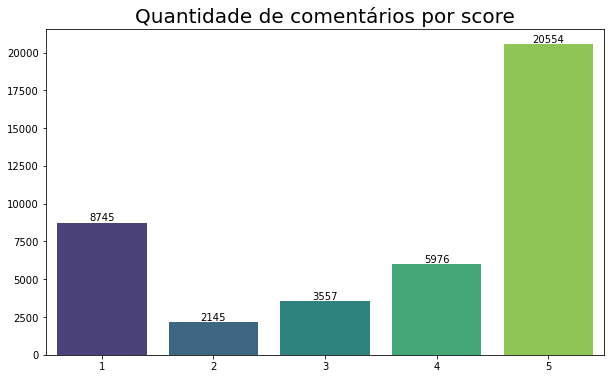

In [8]:
# Criando um datafrem que contem as quantidade de acordo com o score
quantidade = pd.DataFrame(dataset['review_score'].value_counts()).sort_index()

# plotando o gráfico de barra
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(y='review_score', x=quantidade.index, data=quantidade, orient='v', palette='viridis')
ax.set_title('Quantidade de comentários por score', fontdict={'fontsize': 20})
ax.set(ylabel=None, xlabel=None)
ax.bar_label(ax.containers[0])
plt.show()

Com objetivo de criar um modelo de análise sentimental em uma abordagem de Machine Learning supervionada, iremos dividir os sentimetos em três classes: negativo, neutro e positivo. O database não possui uma definição explicita sobre a definição de sentimento para cada comentário. Pensando em uma implementação rápida, utilizaremos a coluna "review_score" para rotular os dados nas três classes já que ela dá uma oa ideia sobre a satisfação do cliente a respeito da compra.

Rotulagem dos dados:
- Positivo (1): Compreende os scores de valores 4 e 5
- Neutro (0): Compreende o score de valor 3
- Negativo (-1): Compreende os scores de valores 1 e 2

In [9]:
# Rotulagem dos dados
score_map = {
    1: -1,
    2: -1,
    3: 0,
    4: 1,
    5: 1
}

dataset['sentiment_label'] = dataset['review_score'].map(score_map)
dataset = dataset[['review_score', 'sentiment_label','review_comment_message']]

In [10]:
dataset.head()

,review_score,sentiment_label,review_comment_message
0,5,1,Recebi bem antes do prazo estipulado.
1,5,1,Parabéns lojas lannister adorei comprar pela I...
2,4,1,aparelho eficiente. no site a marca do aparelh...
3,4,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,1,"Vendedor confiável, produto ok e entrega antes..."


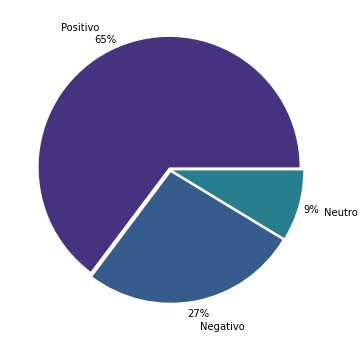

In [11]:
sentiment = pd.DataFrame(dataset['sentiment_label'].value_counts())
labels = ['Positivo', 'Negativo', 'Neutro']

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('viridis')
ax.pie(sentiment['sentiment_label'],labels= labels,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, explode = [0.02, 0.02, 0.02], colors=colors)
plt.show()

## 4. Criando uma BaseLine

### 4.1. Bag of Words: criando representações da linguagem humana.

In [12]:
# Vetorizando as 50 palavras com mais ocorrência da coluna "review_comment_message"
vetorizar = CountVectorizer(max_features=50)
bag_of_words = vetorizar.fit_transform(dataset['review_comment_message'])
bag_of_words.shape

(40977, 50)

In [13]:
# Visualização das 50 palavras com mais ocorrência
print(vetorizar.get_feature_names_out())

['ainda' 'antes' 'as' 'até' 'bem' 'bom' 'chegou' 'com' 'como' 'compra'
 'comprei' 'da' 'de' 'dentro' 'do' 'em' 'entrega' 'entregue' 'estou' 'eu'
 'excelente' 'foi' 'gostei' 'loja' 'mais' 'mas' 'me' 'meu' 'minha' 'muito'
 'na' 'no' 'não' 'os' 'para' 'por' 'prazo' 'produto' 'qualidade' 'que'
 'recebi' 'recomendo' 'rápida' 'super' 'só' 'tudo' 'um' 'uma' 'veio'
 'ótimo']


### 4.2. Modelo: LogisticRegression 

In [14]:
# verificar a proporção do review score
dataset.review_score.value_counts().sort_index()

1     8745
2     2145
3     3557
4     5976
5    20554
Name: review_score, dtype: int64

In [15]:
# Separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(bag_of_words,\
                                                        dataset['sentiment_label'],\
                                                            stratify=dataset['sentiment_label'],
                                                                random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(30732, 50)
(10245, 50)
(30732,)
(10245,)


In [16]:
regressao_logistica = LogisticRegression(solver = "lbfgs")
regressao_logistica.fit(x_train, y_train)
regressao_logistica.score(x_test, y_test)

0.7958028306490971

### 4.3. Função para classificar sentimentos

A função classificar_texto será utilizada para gerar o Score do modelo de LogisticRegression para facilitar a comparação com a baseline. Todos os parâmetros ficaram constante para ser possível analise apenas as mudanças realizadas nos reviews.

In [17]:
def classificar_texto(dataset, coluna_texto, coluna_classificacao):
    '''
    dataset: Dataframe (Pandas)
        Conjunto de dados 
    coluna_texto: String
        Nome da coluna que possui os textos a serem claficados
    coluna_classificacao: String
        Nome da coluna que possui os valores de classficação dos reviews
    '''
    vetorizar = CountVectorizer(max_features=50)
    bag_of_words = vetorizar.fit_transform(dataset[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              dataset[coluna_classificacao],
                                                              stratify=dataset[coluna_classificacao],
                                                              random_state = 42)
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)


In [18]:
baseline = classificar_texto(dataset, "review_comment_message", 'sentiment_label')
baseline

0.7959980478282089

## 5. Visualizações

### 5.1. WordCloud

Word cloud é uma imagem gerada com as principais palavras de um texto distribuídas em um espaço, de modo que o tamanho de cada palavra é proporcional à sua frequência de aparição nos dados. Ela vai ajudar a ter ideias de como realizar tratamentos em seu texto para melhorar os resultados.Plotando as palavras mais frequentes para todos os tipos de comentarios através do WordCloud:

In [19]:
# Fazendo um list compression para capturar todas as palavras de todos rewies
todas_palavras = ' '.join([texto for texto in dataset.review_comment_message])
len(todas_palavras)

2853542

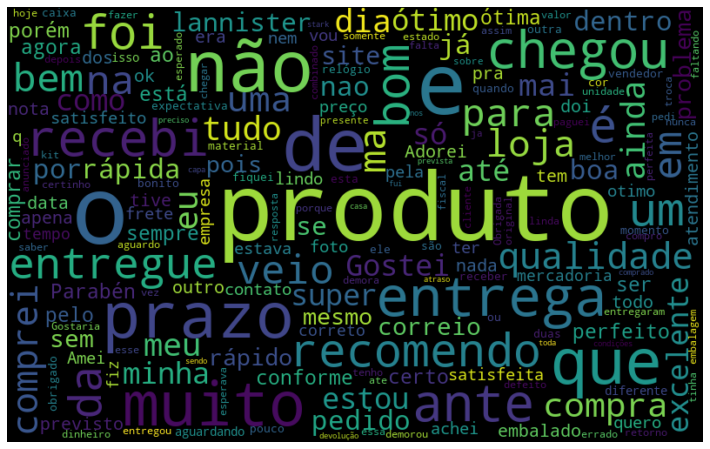

In [20]:
%matplotlib inline

# gerando a wordcloud
nuvem_palavras = WordCloud(width=800,\
                             height=500, 
                                max_font_size=110,\
                                    collocations=False).generate(todas_palavras)

# trasformando o objeto gerado em uma imagem
plt.figure(figsize=(14, 8))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

Sendo a base de dados um review da venda, logo, a palavra que possui maior número de ocorrência é "produto". Há também grande número de ocorrência de palavras que não agregam semanticamente no momento de criação do modelo, como por exemplo, "o", "que", "e", "da", "de" e "como".

Definindo uma função para criação das nuvem de palavras de acordo com o valor do score:

In [21]:
def nuvem_palavras(dataset, coluna_texto, n_score):
    '''
    dataset: Dataframe (Pandas)
        Conjunto de dados 
    coluna_texto: String
        Nome da coluna que possui os textos a serem claficados
    n_score: Integer
        Valor do Score que se dejesa plotar a nuvem de palavras (WordCloud)
    '''
    score = dataset[dataset['sentiment_label'] == n_score]
    palavras = ' '.join([texto for texto in score[coluna_texto]])
    # gerando a wordcloud
    nuvem_palavras = WordCloud(width=800,\
                                height=500, 
                                    max_font_size=110,\
                                        collocations=False).generate(palavras)

    # trasformando o objeto gerado em uma imagem
    plt.figure(figsize=(14, 8))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

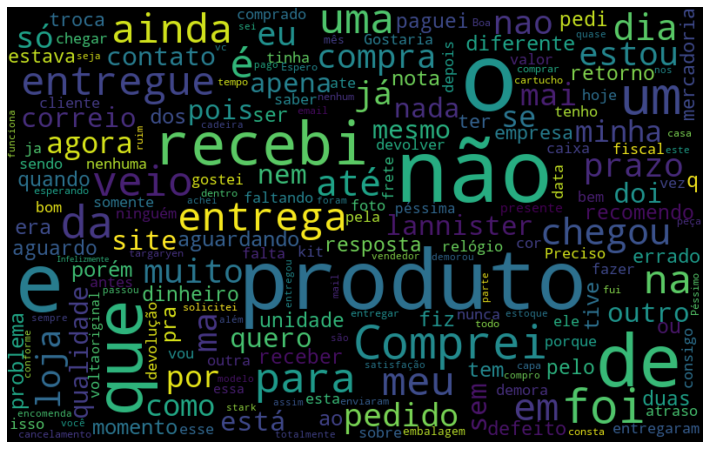

In [22]:
# Para o sentimento negativo
nuvem_palavras(dataset, 'review_comment_message', -1)

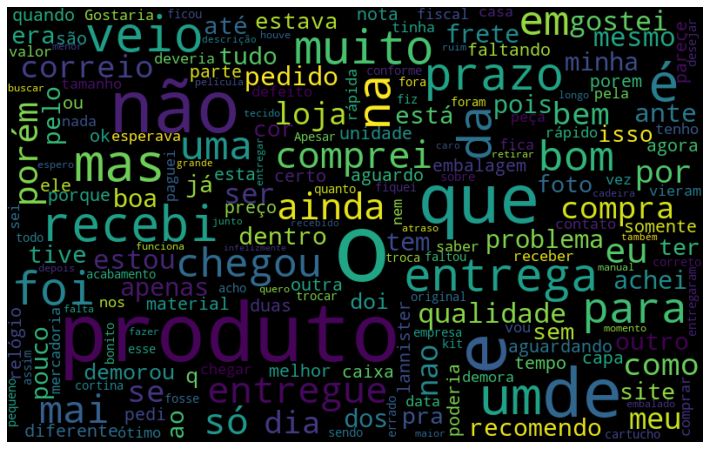

In [23]:
# Para o sentimento neutro
nuvem_palavras(dataset, 'review_comment_message', 0)

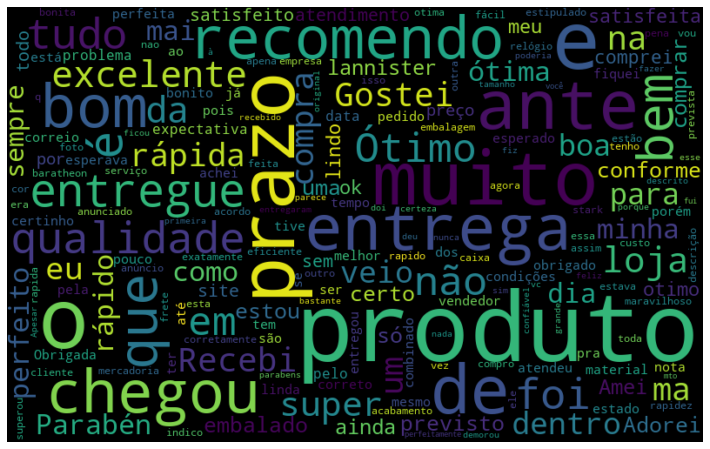

In [24]:
# Para o sentimento positivo
nuvem_palavras(dataset, 'review_comment_message', 1)

## 6. Expressões Regulares

Sabendo que os dados são fruto de comentarios da internet, provalmente será necessário lidar com algumas expressões regulares. Iremos realizar o pré-processamento dos dados, substituido as expressões regulares por termos que as caracterizem de forma simples.

### 6.1. Datas

As datas são expressões bastantes comuns em reviews de clientes sobre itens comprados online. Vamos criar uma função para substituir todas as datas pela string 'data'.

In [25]:
def re_dates(texto_lista):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    '''
    # Criando a RegEx
    padrao = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(padrao, ' data ', r) for r in texto_lista]

In [26]:
# Criando a lista de comentarios
reviews = list(dataset['review_comment_message'].values)
# Aplicando o re_dates
review_dates = re_dates(reviews)
dataset['re_dates'] = review_dates

### 6.2. Dinheiros (valores em reais)

Outro padrão que é bastante comum em reviews de compra é a representação de dinheiro (R$_,_). Iremos trasformar todas os valores em uma string 'valor'.

In [27]:
def re_money(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [28]:
# Aplicando o re_money
review_money = re_money(review_dates)
dataset['re_money'] = review_money

### 6.3. Negação

Na remoção de StopWords, provavelmente perderíamos o significado de algumas frases de negação, já que o termo 'não' é removido. Então, por causa disso, iremos substituir todos as RegEx que representa o termo 'não' por negação.

In [29]:
def re_negation(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [30]:
# Aplicando o re_money
reviews_negation = re_money(review_money)
dataset['re_negation'] = reviews_negation

### 6.4. Caracteres Especiais (incluindo emojis)

A utilização de caracteres especiais e emojis são bastantes utilizados em comentarios onlines. Logo, iremos remover todos.

In [31]:
def re_special_chars(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    return [re.sub('\W', ' ', r) for r in text_list]

In [32]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
dataset['re_special_chars'] = reviews_special_chars

### 6.5. Espaços (whitespaces) adicionais

Iremos remover os espaços desnecessários já existentes ou criados devido as etapas anteriores.

In [33]:
def re_whitespaces(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [34]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
dataset['re_whitespaces'] = reviews_whitespaces

### 6.6 Números

Removeremos todos os números nas avaliações e substituí-los por outra string "numero" para que gere nem uma perda de infomação.

In [35]:
def re_numbers(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

In [36]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_whitespaces)
dataset['re_numbers'] = reviews_numbers

## 7. Removendo Stop Words

As stop words são palavras que não apresentam relevância em determinado contexto e podem ser removidas sem perda semântica da frase. Essa lista não é fixa e universal, podendo ser alterada dependendo do contexto e idioma. Livrar-se dessas palavras faz muito sentido para qualquer tarefa de Processamento de Linguagem Natural.

In [38]:
# Baixando o conjunto de palavras Stop Words da NLTK
nltk.download('stopwords')
palavras_irrelevantes = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# Visualização de 15 StopWord definidas na biblioteca NLTK
print(palavras_irrelevantes[:15])

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da']


In [40]:
# Definição da função para remover as StopWords e trasformar os comentarios em minusculo
def stopwords_removal(texto_lista, stopwords_lista):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto em que será removida as topwords
    stopwords_lista: list
        Lista contendo as stopword
    '''
    return [c.lower() for c in texto_lista.split() if c.lower() not in stopwords_lista]

In [41]:
# Removendo as stopword do dataset
reviews_stopwords = [' '.join(stopwords_removal(review, palavras_irrelevantes)) for review in reviews_numbers]
dataset['stopwords_removed'] = reviews_stopwords

## 8. Normalização de textos

In [42]:
# Defining a function to remove the stopwords and to lower the comments
def normalization_process(texto_lista):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto em que será normalizada
    '''
    return [unidecode.unidecode(c) for c in texto_lista.split()]

In [43]:
# Applying stemming and looking at some examples
reviews_normalization = [' '.join(normalization_process(review)) for review in reviews_stopwords]
dataset['reviews_normalization'] = reviews_normalization

## 9. Stemming

Stemming é a técnica que transforma as flexões de uma palavra em um núcleo comum (tronco).  Essa técnica normaliza as palavras de forma a evitar suas flexões e derivações. Existem diversos algoritmos para realizar a “stemmização", seja em Português, sejam em outros idiomas.

In [44]:
# Realizando download do stemming para a linguagem Pt-br
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [45]:
def stemming_process(texto_lista, stemmer=RSLPStemmer()):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto em que será normalizada
    stemmer: class, default: RSLPStemmer()
        Tipo de Stemmer que será aplicado ao texto
    '''
    
    return [stemmer.stem(c) for c in texto_lista.split()]

In [46]:
# Aplicando o processor de Stemmer nos dados
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_normalization]
dataset['reviews_stemmer'] = reviews_stemmer

## 10. Extração de Features de texto

A extração de features de texto envolve resumir automaticamente o texto e encontrar palavras importantes. Um exemplo disso é a extração de palavras-chave, que extrai as palavras mais importantes do texto, o que pode ser útil para a otimização de mecanismos de busca. Para facilitar nossa análise, vamos definir uma função que recebe um texto e um objeto vetorizador e aplica a extração de recursos no respectivo texto.

In [47]:
def extract_features_from_corpus(texto_lista, vectorizer, df=False):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto em que será normalizada
    vectorizer: object
        Engenharia utilizada para extração das features de texto
    '''

    # Extracting features
    corpus_features = vectorizer.fit_transform(texto_lista).toarray()
    features_names = vectorizer.get_feature_names_out()
    df_corpus_features = None
    if df:
        # Transforming into a dataframe to give interpetability to the process
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

### 10.1. CountVectorizer

O CountVectorizer converte uma coleção de documentos de texto em uma matriz de contagens de token , ou seja, essa implementação produz uma representação esparsa das contagens de frequência das palavras ao longo de todo o dataset.

In [48]:
# Criando a classe de objeto CountVectorizer
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=palavras_irrelevantes)

# Extraindo as features de texto a partir do CountVectorizer
_, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, True)
df_countv_features.head()

,abr,acab,ach,acontec,acord,ador,adquir,agil,agor,aguard,...,val,vc,vei,vem,vend,ver,vez,vier,volt,vou
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [49]:
df_countv_features.to_numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 10.2. TF-IDF

O valor TF-IDF (Term Frequency-Inverse Document Frequency), é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.  O TF-IDF irá contar a frequência das palavras e atribui pesos as mesmas, ponderando-as em todo o dataset. Se uma palavra aparece muitas vezes, ela perde o poder de diferenciação, logo, possuirá um peso menor.

In [50]:
# Criando a classe de objeto TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=palavras_irrelevantes)

# Extraindo as features de texto a partir do TF-IDF
_, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, True)
df_tfidf_features.head()

,abr,acab,ach,acontec,acord,ador,adquir,agil,agor,aguard,...,val,vc,vei,vem,vend,ver,vez,vier,volt,vou
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.307476,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.196667,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.591471,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.455039,0.0,0.000000,0.0,0.0,0.0


In [51]:
tfidf = TfidfVectorizer(lowercase=False, max_features=50)
tfidf_tratados = tfidf.fit_transform(dataset['reviews_stemmer'])

x_train, x_test, y_train, y_test = train_test_split(tfidf_tratados,
                                                        dataset['review_score'],
                                                        stratify=dataset['review_score'],
                                                        random_state = 42)

regressao_logistica.fit(x_train, y_train)
acuracia_tfidf = regressao_logistica.score(x_test, y_test)
acuracia_tfidf

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6451927769643728

A aplicacção do TF-IDF não resultou em melhoras significativas para melhora da acuracia do modelo. O metodo resultou em uma melhora de aproximadamente 0.3% de melhora em comparação com a baseline.

## 11. Ngrams

O método que estávamos utilizando até agora (bag of words), tanto com contagem de frequência quanto aplicando o TF-IDF, não gera um valor que preserve a sequência de palavras. O N-grams considera essencialmente uma sequência de palavras que aparecem na mesma "janela" ao mesmo tempo.

In [52]:
def ngrams_count(texto_df, ngram_range, n=-1):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    '''
    Argumentos:
    ----------
    texto_df: pd.DataFrame
        Coluna contendo o texto a ser analisado
    ngram_range: Tuple(min_n, max_n)
        O limite inferior e superior do intervalo de valores n para diferentes n-grams de palavras ou carateres n-grams a serem extraídos
    n: Int, default=-1
        Número de elementos a serem selecionado no dataframe
    '''

    
    # Usando CountVectorizer para construir um pacote de palavras usando o o texto_lista fornecido
    vectorizer = CountVectorizer(ngram_range=ngram_range).fit(texto_df)
    bag_of_words = vectorizer.transform(texto_df)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Retornando o DataFrame com os N-Grams
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [69]:
# Dividindo o dataset em comentarios positivos, neutros e negativos
comentarios_positivos = dataset[dataset['sentiment_label'] == 1]['reviews_stemmer']
comentarios_neutros = dataset[dataset['sentiment_label'] == 0]['reviews_stemmer']
comentarios_negativos = dataset[dataset['sentiment_label'] == -1]['reviews_stemmer']

# Extraindo os TOP 10 unigrams por sentimento
unigrams_pos = ngrams_count(comentarios_positivos, (1, 1), 10)
unigrams_neu = ngrams_count(comentarios_neutros, (1, 1), 10)
unigrams_neg = ngrams_count(comentarios_negativos, (1, 1), 10)

# Extraindo os TOP 10 unigrams e bigramas por sentimento
uni_bi_grams_pos = ngrams_count(comentarios_positivos, (1, 2), 10)
uni_bi_rams_neu = ngrams_count(comentarios_neutros, (1, 2), 10)
uni_bi_grams_neg = ngrams_count(comentarios_negativos, (1, 2), 10)

# Extraindo os TOP 10 bigramas por sentimento
bigrams_pos = ngrams_count(comentarios_positivos, (2, 2), 10)
bigrams_neu = ngrams_count(comentarios_neutros, (2, 2), 10)
bigrams_neg = ngrams_count(comentarios_negativos, (2, 2), 10)

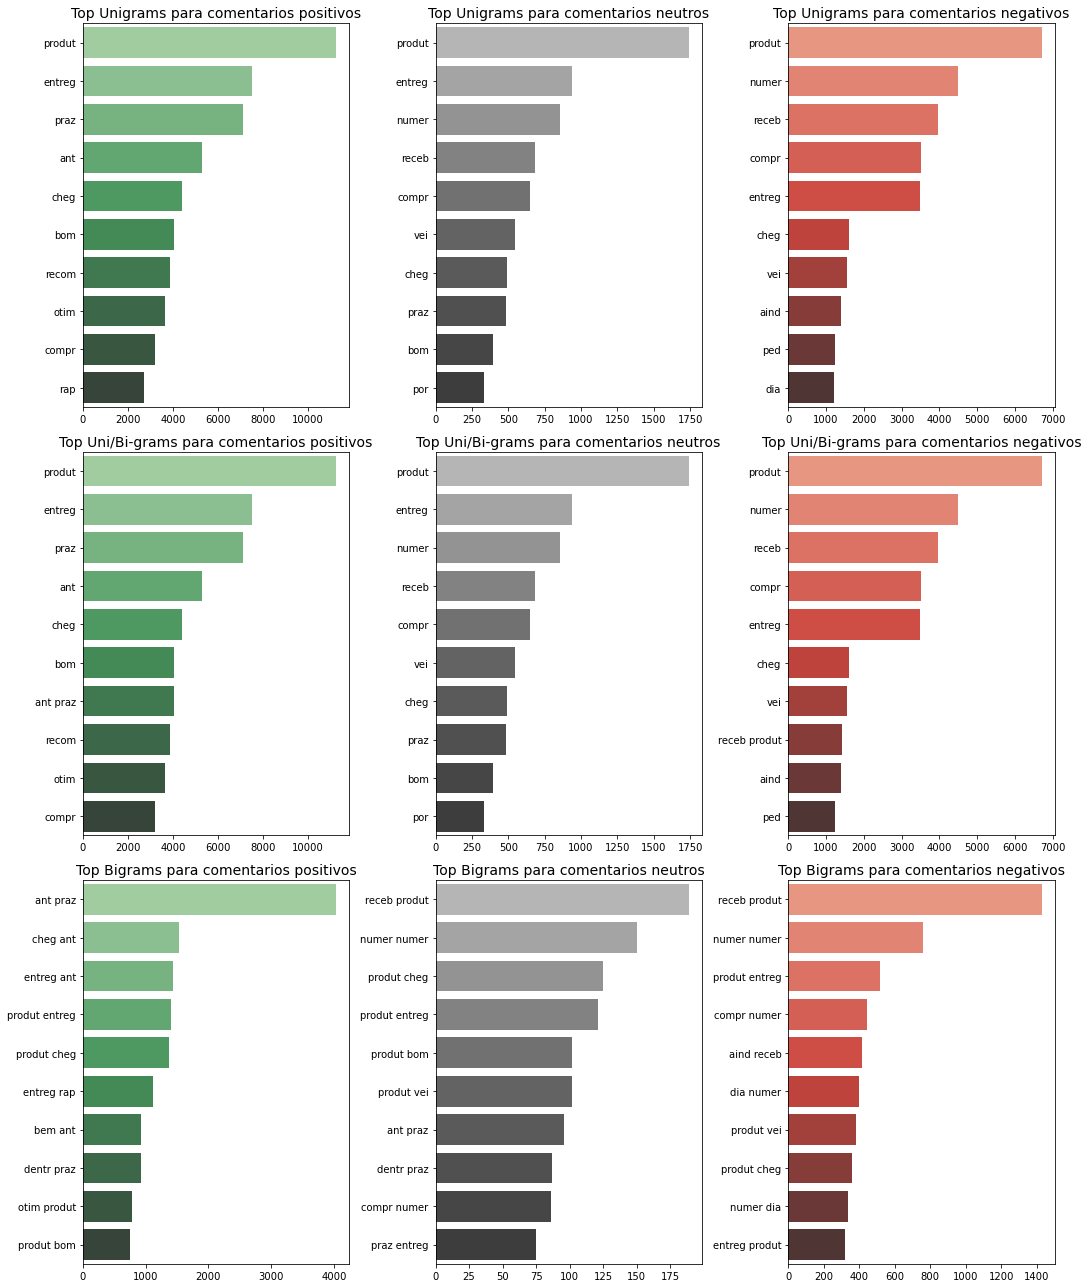

In [71]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams para comentarios positivos': unigrams_pos,
    'Top Unigrams para comentarios neutros': unigrams_neu,
    'Top Unigrams para comentarios negativos': unigrams_neg,
    'Top Uni/Bi-grams para comentarios positivos': uni_bi_grams_pos,
    'Top Uni/Bi-grams para comentarios neutros': uni_bi_rams_neu,
    'Top Uni/Bi-grams para comentarios negativos': uni_bi_grams_neg,
    'Top Bigrams para comentarios positivos': bigrams_pos,
    'Top Bigrams para comentarios neutros': bigrams_neu,
    'Top Bigrams para comentarios negativos': bigrams_neg,
}


fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 18))
i, j = 0, 0
colors = ['Greens_d', 'Greys_d', 'Reds_d']

for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    # format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 3:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

## 12. Pipeline